# 04-Time Series Forecasting: Tutorial 2

### - ARIMA 
### - Seasonal ARIMA (SARIMA)
### - Prophet

### 1. 모듈 불러오기

In [1]:
!pip install pmdarima

import os
import datetime
import itertools
import warnings
warnings.filterwarnings(action='ignore') 

import numpy as np
import pandas as pd
import pandas_datareader as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

!git clone https://github.com/hansam95/LG-Elec-Day3.git

Importing plotly failed. Interactive plots will not work.


### 2. 데이터 불러오기

In [2]:
# 월별 비행기 탑승객 데이터
# data = pd.read_csv('./data/AirPassengers.csv')
data = pd.read_csv('/content/LG-Elec-Day3/data/AirPassengers.csv')
data = data.rename(columns={'Month': 'month', '#Passengers': 'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


### 3. Box-Jenkins ARIMA Procedure
-  3.1 Data Preprocessing
-  3.2 Identify Model to be Tentatively Entertainted
-  3.3 Estimate Parameters
-  3.4 Diagnosis Check
-  3.5 use Model to Forecast

<img src='./image/img11.png' width='800'></img>

#### 3.1 Data Preprocessing

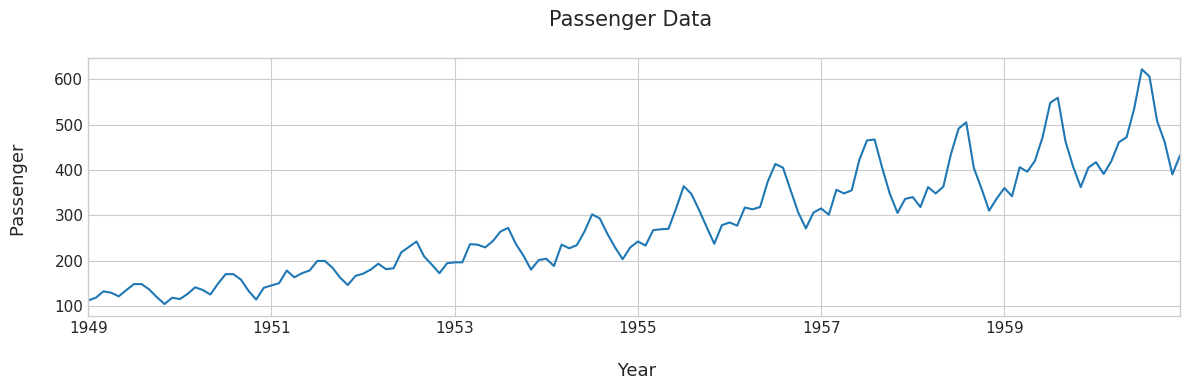

In [3]:
'''
데이터 시각화를 통해 전체 개요 확인
'''
data.plot(figsize=(12,4)) # color='green', linestyle='--', linewidth=1

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend('')

plt.title('Passenger Data \n', fontsize=15)
plt.xlabel('\n Year', fontsize=13)
plt.ylabel('Passenger \n', fontsize=13)
plt.tight_layout()
plt.show()

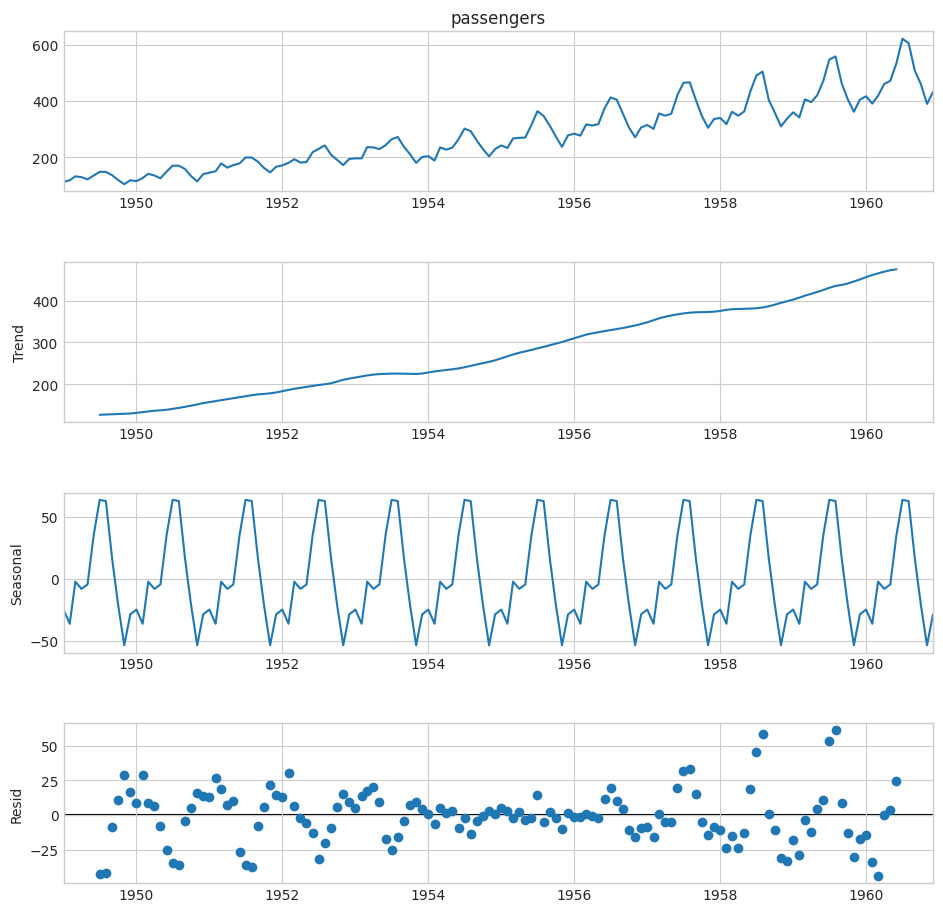

In [4]:
# Seasonal decomposition plot: Seasonal decomposition using moving averages.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

# Observed: observed data
# Trend: The estimated trend component
# Seasonal: The estimated seasonal component
# resid: The estimated residuals

decomposition = sm.tsa.seasonal_decompose(data['passengers'],  model='additive')

fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

#### 3.2 Identify Model to be Tentatively Entertainted

In [5]:
# Train:Test = 8:2
train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [6]:
train.tail()

,passengers
month,
1958-03-01,362
1958-04-01,348
1958-05-01,363
1958-06-01,435
1958-07-01,491


In [7]:
test.head()

,passengers
month,
1958-08-01,505
1958-09-01,404
1958-10-01,359
1958-11-01,310
1958-12-01,337


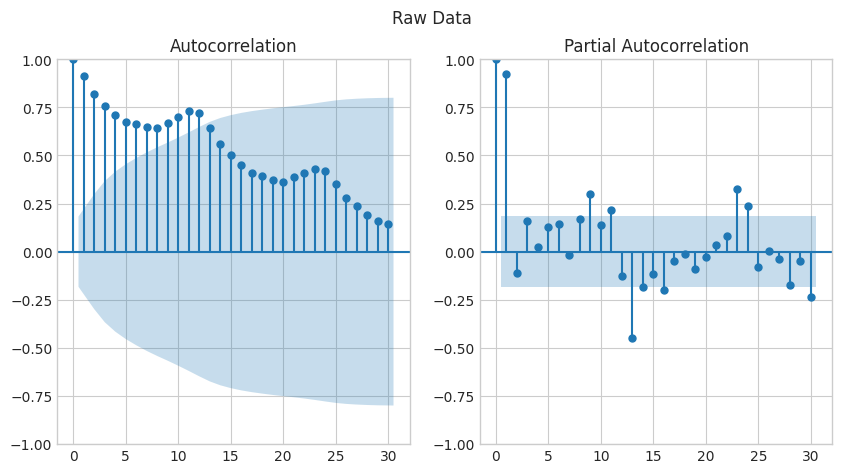

In [8]:
# ACF, PACF plot 

# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=30, ax=ax[1]); # Modify not to generate graph twice
# ACF 0으로 빠르게 수렴하지 않음 -> 정상성 만족 X

In [9]:
# Differencing

diff_train = train.copy()
# 1차차분 값 계산
diff_train = diff_train['passengers'].diff()
diff_train = diff_train.dropna()
print('####### Raw Data #######')
print(train)
print('### Differenced Data ###')
print(diff_train)

####### Raw Data #######
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
### Differenced Data ###
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


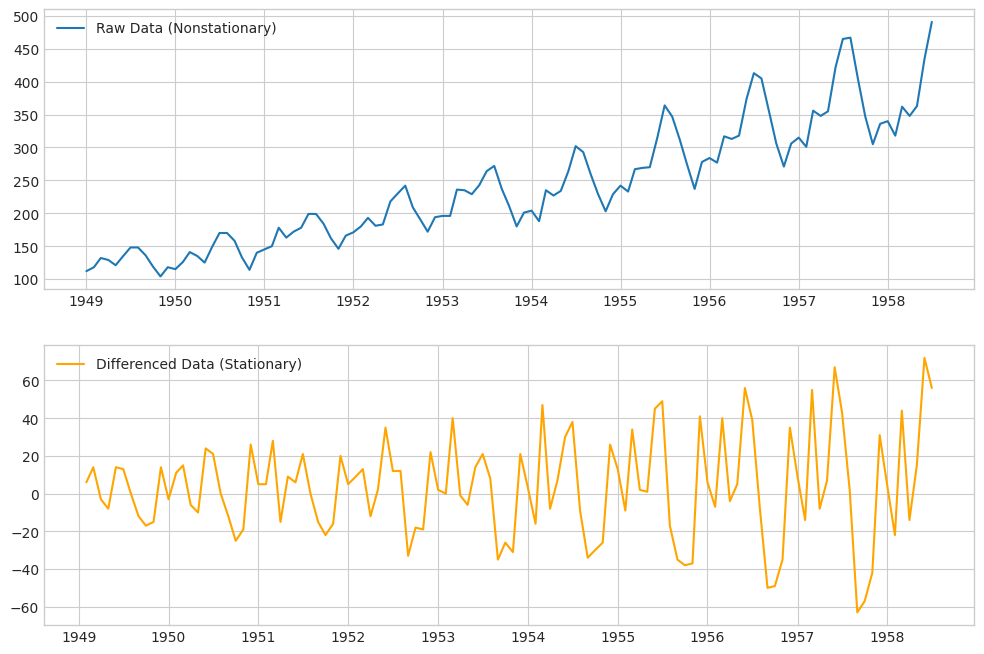

In [10]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train['passengers'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train,'orange') # first difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

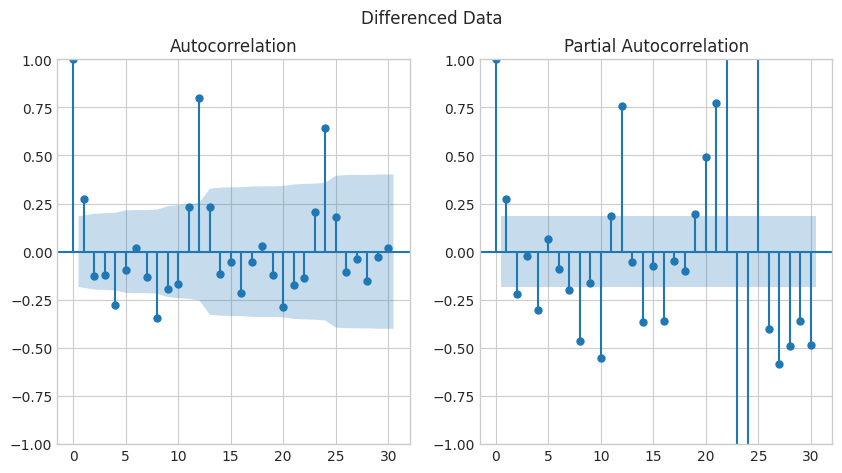

In [11]:
# ACF, PACF plot 

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train.values.squeeze(), lags=30, ax=ax[1]); # Modify not to generate graph twice

#### 3.3 Estimate Parameters

In [12]:
# ARIMA model fitting
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

ARIMA_model = ARIMA(train.values, order=(1,1,0))
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -532.268
Date:                Wed, 08 Feb 2023   AIC                           1068.536
Time:                        17:03:27   BIC                           1074.008
Sample:                             0   HQIC                          1070.757
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2904      0.089      3.278      0.001       0.117       0.464
sigma2       664.7320     89.253      7.448      0.000     489.800     839.664
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.57   Prob(JB):                         0.20
Heteroskedasticity (H):               6.18   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 3.4.1 Diagnosis Check - ARIMA

In [13]:
# Parameter search 

print('Examples of parameter combinations for ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

aic_all=[]
for i in pdq:
    model = ARIMA(train.values, order=(i))
    ARIMA_model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(ARIMA_model_fit.aic,2)}')
    aic_all.append(round(ARIMA_model_fit.aic,2))

Examples of parameter combinations for ARIMA...
ARIMA: (0, 1, 0) >> AIC : 1076.27
ARIMA: (0, 1, 1) >> AIC : 1063.65
ARIMA: (0, 1, 2) >> AIC : 1060.69
ARIMA: (1, 1, 0) >> AIC : 1068.54
ARIMA: (1, 1, 1) >> AIC : 1058.25
ARIMA: (1, 1, 2) >> AIC : 1057.33
ARIMA: (2, 1, 0) >> AIC : 1065.64
ARIMA: (2, 1, 1) >> AIC : 1058.65
ARIMA: (2, 1, 2) >> AIC : 1057.52


In [14]:
# Search optimal parameters
# AIC은 낮을수록 좋은 값 / AIC 기준으로 best (p,d,q) 찾기
for i, aic in enumerate(aic_all):
    if aic == min(aic_all):
        ARIMA_optimal = [(pdq[i], aic)]

ARIMA_optimal

[((1, 1, 2), 1057.33)]

In [15]:
ARIMA_model_opt = ARIMA(train.values, order=ARIMA_optimal[0][0])
ARIMA_model_opt_fit = ARIMA_model_opt.fit()

ARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -524.664
Date:                Wed, 08 Feb 2023   AIC                           1057.328
Time:                        17:03:28   BIC                           1068.272
Sample:                             0   HQIC                          1061.769
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5387      0.128      4.219      0.000       0.288       0.789
ma.L1         -0.2053      0.122     -1.688      0.091      -0.444       0.033
ma.L2         -0.5606      0.084     -6.647      0.000      -0.726      -0.395
sigma2       578.5728    105.827      5.467      0.000     371.155     785.991
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 4.81
Prob(Q):                              0.47   Prob(JB):                         0.09
Heteroskedasticity (H):               5.54   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 3.5.1 use Model to Forecast - ARIMA

In [16]:
ARIMA_prediction = ARIMA_model_opt_fit.get_forecast(len(test)).summary_frame()
ARIMA_prediction.head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,482.493841,24.053540,435.349770,529.637912
1,450.831653,40.090316,372.256078,529.407228
2,433.775780,46.173568,343.277249,524.274312
3,424.588076,49.547407,327.476944,521.699209
4,419.638819,51.859228,317.996599,521.281039


In [17]:
ARIMA_test_pred = ARIMA_prediction['mean']
ARIMA_test_ub = ARIMA_prediction['mean_ci_upper']
ARIMA_test_lb = ARIMA_prediction['mean_ci_lower']
predict_index = list(test.index)

In [18]:
'''
Quantitative Evaluation
'''
print('ARIMA')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')

ARIMA
------------------------------
MSE: 6828.67
RMSE: 82.64
MAE: 62.06
R2 score: -0.12


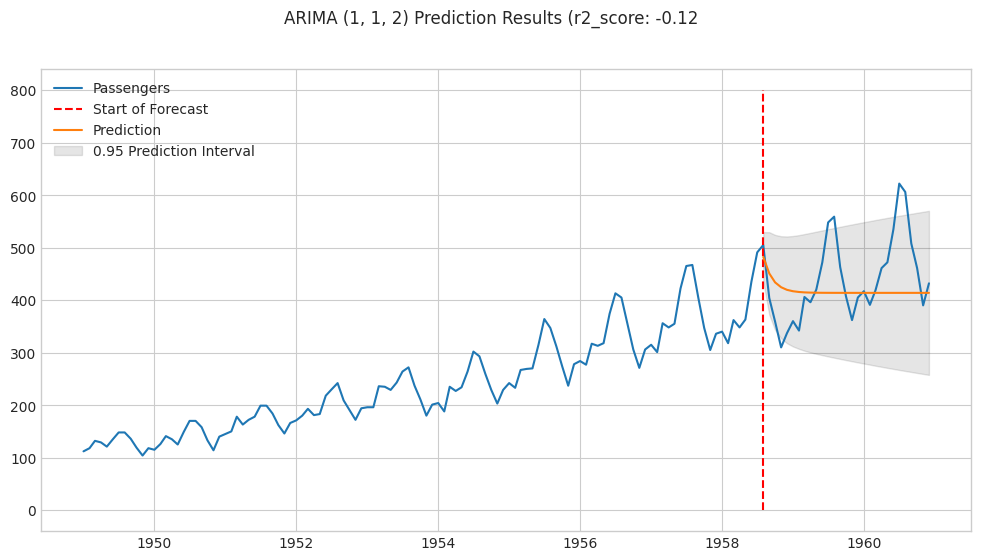

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('1958-08-01','%Y-%m-%d'), 0, 800, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, ARIMA_test_pred, label = 'Prediction')
ax.fill_between(predict_index, ARIMA_test_lb, ARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {ARIMA_optimal[0][0]} Prediction Results (r2_score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')
plt.show()

#### 3.4.2 Diagnosis Check - SARIMA

In [20]:
# Parameter search

print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

aic=[]
params=[]
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train.values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))  
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 757.83
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 756.99
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 758.83
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 756.96
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 758.92
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 754.42
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 758.87
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 760.73
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28952D+00    |proj g|=  1.22026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function v

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 754.9
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 756.01
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 756.38
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 757.65
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 756.17
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 758.11
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 751.73
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 757.99
At iterate   30    f=  3.23889D+00    |proj g|=  2.01459D-03

At iterate   35    f=  3.23886D+00    |proj g|=  6.87843D-05

At iterate   40    f=  3.23886D+00    |proj g|=  2.51418D-05

At iterate   45    f=  3.23885D+00    |proj g|=  1.63797D-04

At iterate   50    f=  3.23870D+00    |proj g|=  2.72263D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F 

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)(1, 1, 2, 12) >> AIC : 752.53
SARIMA: (1, 1, 1)(2, 1, 0, 12) >> AIC : 758.03


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)(2, 1, 1, 12) >> AIC : 754.16
SARIMA: (1, 1, 1)(2, 1, 2, 12) >> AIC : 760.17
SARIMA: (1, 1, 2)(0, 1, 0, 12) >> AIC : 757.92
SARIMA: (1, 1, 2)(0, 1, 1, 12) >> AIC : 758.44
SARIMA: (1, 1, 2)(0, 1, 2, 12) >> AIC : 759.63
At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46960D+00    |proj g|=  2.31984D-01

At iterate    5    f=  3.28215D+00    |proj g|=  2.20763D-02

At iterate   10    f=  3.24037D+00    |proj g|=  5.81855D-02

At iterate   15    f=  3.22094D+00    |proj g|=  5.77789D-03

At iterate   20    f=  3.21985D+00    |proj g|=  4.47193D-04

At iterate   25    f=  3.21985D+00    |proj g|=  4.54667D-04

At iterate   30    f=  3.21983D+00    |proj g|=  1.82549D-03

At iterate   35    f=  3.21975D+00    |proj g|=  5.86841D-04

At iterate   40    f=  3.21972D+00    |proj g|=  3.06099D-04

At iterate   45    f=  3.21971D+00    |proj g|=  2.90667D-04

At iterate   50    f=  3.21970D+00    |proj g|=  2.88921D-04

           * * *

Tit   = tota

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)(1, 1, 2, 12) >> AIC : 754.53
SARIMA: (1, 1, 2)(2, 1, 0, 12) >> AIC : 759.92
SARIMA: (1, 1, 2)(2, 1, 1, 12) >> AIC : 756.17
SARIMA: (2, 1, 0)(0, 1, 0, 12) >> AIC : 756.77
SARIMA: (2, 1, 0)(0, 1, 1, 12) >> AIC : 757.23
At iterate   10    f=  3.25314D+00    |proj g|=  5.31582D-04

At iterate   15    f=  3.25313D+00    |proj g|=  2.60628D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   2.006D-06   3.253D+00
  F =   3.2531283360807968     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 0)(2, 1, 2, 12) >> AIC : 762.33
SARIMA: (2, 1, 1)(0, 1, 0, 12) >> AIC : 757.98
At iterate   10    f=  3.28374D+00    |proj g|=  4.89632D-02

At iterate   15    f=  3.25354D+00    |proj g|=  1.82075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   4.116D-06   3.254D+00
  F =   3.2535357788401340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25801D+00    

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)(1, 1, 2, 12) >> AIC : 754.53
SARIMA: (2, 1, 1)(2, 1, 0, 12) >> AIC : 759.98


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)(2, 1, 1, 12) >> AIC : 756.17
Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27453D+00    |proj g|=  1.56116D-01

At iterate    5    f=  3.25822D+00    |proj g|=  9.44329D-03

At iterate   10    f=  3.25460D+00    |proj g|=  7.82392D-03

At iterate   15    f=  3.25451D+00    |proj g|=  3.78757D-04

At iterate   20    f=  3.25451D+00    |proj g|=  1.23058D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   1.231D-05   3.255D+00
  F =   3.2545066570499426     

CONVE

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)(2, 1, 2, 12) >> AIC : 70.47
SARIMA: (2, 1, 2)(0, 1, 0, 12) >> AIC : 755.2
SARIMA: (2, 1, 2)(0, 1, 1, 12) >> AIC : 755.99
SARIMA: (2, 1, 2)(0, 1, 2, 12) >> AIC : 759.77
SARIMA: (2, 1, 2)(1, 1, 0, 12) >> AIC : 755.82
SARIMA: (2, 1, 2)(1, 1, 1, 12) >> AIC : 757.71


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(1, 1, 2, 12) >> AIC : 752.34
At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44448D+00    |proj g|=  3.83504D-01

At iterate    5    f=  3.27164D+00    |proj g|=  1.91820D-02

At iterate   10    f=  3.25608D+00    |proj g|=  1.16135D-02

At iterate   15    f=  3.25557D+00    |proj g|=  1.59466D-03

At iterate   20    f=  2.71628D-01    |proj g|=  3.38951D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23    104      2     0     0   2.516D+04   2.368D-01
  F =  0.23682336300993140     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-

In [59]:
# Search optimal parameters
SARIMA_optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
SARIMA_optimal

[(((2, 1, 1), (2, 1, 2, 12)), 70.47)]

In [60]:
SARIMA_model_opt = SARIMAX(train.values, order=SARIMA_optimal[0][0][0], seasonal_order = SARIMA_optimal[0][0][1])
SARIMA_model_opt_fit = SARIMA_model_opt.fit()

SARIMA_model_opt_fit.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 -27.235
Date:                                 Wed, 08 Feb 2023   AIC                             70.469
Time:                                         17:06:04   BIC                             91.469
Sample:                                              0   HQIC                            78.973
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2101   3.27e-08   6.42e+06      0.000       0.210       0.210
ar.L2          0.1821   7.57e-10   2.41e+08      0.000       0.182       0.182
ma.L1         -0.3876   1.61e-08  -2.41e+07      0.000      -0.388      -0.388
ar.S.L12       0.0009   1.17e-07   7808.009      0.000       0.001       0.001
ar.S.L24       0.9991   1.46e-08   6.82e+07      0.000       0.999       0.999
ma.S.L12      -0.0009   2.51e-08  -3.77e+04      0.000      -0.001      -0.001
ma.S.L24      -0.9962      7e-10  -1.42e+09      0.000      -0.996      -0.996
sigma2        67.9771   2.22e-11   3.06e+12      0.000      67.977      67.977
===================================================================================
Ljung-Box (L1) (Q):                  40.02   Jarque-Bera (JB):              3760.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             5.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+23. Standard errors may be unstable.
"""

#### 3.5.2 use Model to Forecast - SARIMA

In [64]:
SARIMA_prediction = SARIMA_model_opt_fit.get_forecast(len(test))
SARIMA_test_pred = SARIMA_prediction.predicted_mean
SARIMA_test_ub = SARIMA_prediction.conf_int()[:,0]
SARIMA_test_lb = SARIMA_prediction.conf_int()[:,1]
predict_index = list(test.index)

In [65]:
'''
Quantitative Evaluation
'''
print('SARIMA')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, SARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SARIMA_test_pred), 2)}')

SARIMA
------------------------------
MSE: 33104915.1
RMSE: 5753.69
MAE: 5696.54
R2 score: -5422.04


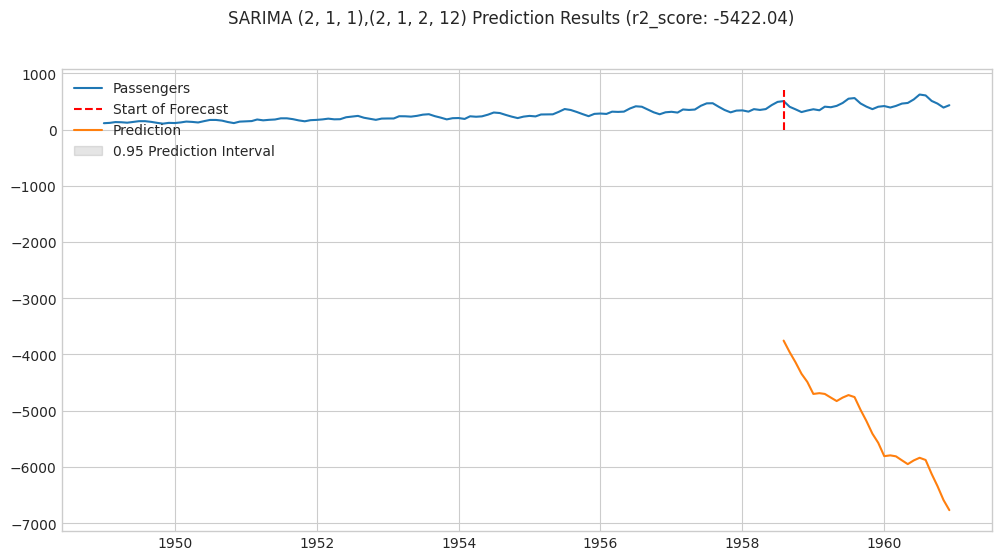

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('1958-08-01','%Y-%m-%d'), 0, 700, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, SARIMA_test_pred, label = 'Prediction')
ax.fill_between(predict_index, SARIMA_test_lb, SARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {SARIMA_optimal[0][0][0]},{SARIMA_optimal[0][0][1]} Prediction Results (r2_score: {np.round(r2_score(test, SARIMA_test_pred), 2)})')
plt.show()

#### 3.4.3 Diagnosis Check - auto_arima

In [67]:
# Parameter search 

auto_arima_model = auto_arima(train, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12, seasonal=True,
                              d=1, D=1, 
                              max_P=3, max_Q=3,
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.04 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.39 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.79 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=1.97 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.12 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.54 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=2.87 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.44 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=2.47 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=2.71 sec
 ARIMA(0,1,1)(0,1,0)[1

In [68]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Wed, 08 Feb 2023   AIC                            752.557
Time:                                            17:07:22   BIC                            768.307
Sample:                                        01-01-1949   HQIC                           758.934
                                             - 07-01-1958                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.656     112.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.91   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 3.5.3 use Model to Forecast - auto_arima

In [69]:
AUTO_ARIMA_prediction = auto_arima_model.predict(len(test), return_conf_int=True)
AUTO_ARIMA_test_pred = AUTO_ARIMA_prediction[0]
AUTO_ARIMA_test_ub = AUTO_ARIMA_prediction[1][:,0]
AUTO_ARIMA_test_lb = AUTO_ARIMA_prediction[1][:,1]
predict_index = list(test.index)

In [70]:
'''
Quantitative Evaluation
'''
print('AUTO ARIMA')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, AUTO_ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,AUTO_ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, AUTO_ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, AUTO_ARIMA_test_pred), 2)}')

AUTO ARIMA
------------------------------
MSE: 710.43
RMSE: 26.65
MAE: 22.16
R2 score: 0.88


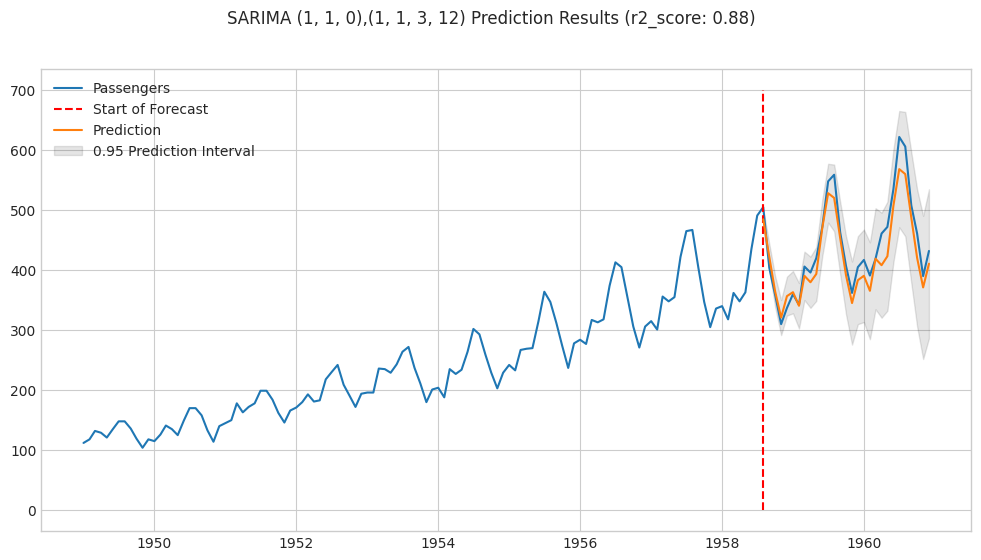

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('1958-08-01','%Y-%m-%d'), 0, 700, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, AUTO_ARIMA_test_pred, label = 'Prediction')
ax.fill_between(predict_index, AUTO_ARIMA_test_lb, AUTO_ARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order},{auto_arima_model.seasonal_order} Prediction Results (r2_score: {np.round(r2_score(test, AUTO_ARIMA_test_pred), 2)})')
plt.show()

### 4. Prophet

In [72]:
train_prophet = train.reset_index()
train_prophet

,month,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
110,1958-03-01,362
111,1958-04-01,348
112,1958-05-01,363
113,1958-06-01,435


In [73]:
train_prophet.columns = ['ds', 'y']
train_prophet

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
110,1958-03-01,362
111,1958-04-01,348
112,1958-05-01,363
113,1958-06-01,435


In [74]:
PRO_model = Prophet()
PRO_model.fit(train_prophet)

17:07:23 - cmdstanpy - INFO - Chain [1] start processing
17:07:23 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
test_prophet = test.reset_index()
test_prophet.columns = ['ds', 'y']
test_data_index = test_prophet[['ds']]
test_data_index

,ds
0,1958-08-01
1,1958-09-01
2,1958-10-01
3,1958-11-01
4,1958-12-01
5,1959-01-01
6,1959-02-01
7,1959-03-01
8,1959-04-01
9,1959-05-01


In [76]:
PRO_prediction = PRO_model.predict(test_data_index)
PRO_prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1958-08-01,401.246072,427.433346,470.402217,401.244427,401.246917,47.296163,47.296163,47.296163,47.296163,47.296163,47.296163,0.0,0.0,0.0,448.542235
1,1958-09-01,404.406036,397.561084,442.816696,404.381853,404.426402,14.332728,14.332728,14.332728,14.332728,14.332728,14.332728,0.0,0.0,0.0,418.738764
2,1958-10-01,407.464066,365.417150,408.680999,407.405891,407.515393,-19.364225,-19.364225,-19.364225,-19.364225,-19.364225,-19.364225,0.0,0.0,0.0,388.099841
3,1958-11-01,410.624030,338.904875,382.473428,410.504398,410.713696,-48.707184,-48.707184,-48.707184,-48.707184,-48.707184,-48.707184,0.0,0.0,0.0,361.916846
4,1958-12-01,413.682060,367.083422,410.328734,413.503295,413.825843,-24.872170,-24.872170,-24.872170,-24.872170,-24.872170,-24.872170,0.0,0.0,0.0,388.809889
5,1959-01-01,416.842024,374.021246,417.389868,416.589686,417.049333,-21.153576,-21.153576,-21.153576,-21.153576,-21.153576,-21.153576,0.0,0.0,0.0,395.688448
6,1959-02-01,420.001988,372.940822,414.660762,419.672717,420.273269,-26.142668,-26.142668,-26.142668,-26.142668,-26.142668,-26.142668,0.0,0.0,0.0,393.859320
7,1959-03-01,422.856149,402.823912,446.255617,422.432196,423.196994,2.047491,2.047491,2.047491,2.047491,2.047491,2.047491,0.0,0.0,0.0,424.903640
8,1959-04-01,426.016113,397.902246,441.167954,425.512467,426.456922,-6.321966,-6.321966,-6.321966,-6.321966,-6.321966,-6.321966,0.0,0.0,0.0,419.694147
9,1959-05-01,429.074143,403.519313,447.272310,428.475319,429.592793,-3.747460,-3.747460,-3.747460,-3.747460,-3.747460,-3.747460,0.0,0.0,0.0,425.326683


In [77]:
PRO_test_pred = PRO_prediction['yhat'].values
PRO_test_ub = PRO_prediction['yhat_upper'].values
PRO_test_lb = PRO_prediction['yhat_lower'].values
predict_index = list(test.index)

In [78]:
'''
Quantitative Evaluation
'''
print('Prophet')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, PRO_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,PRO_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, PRO_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, PRO_test_pred), 2)}')

Prophet
------------------------------
MSE: 1710.13
RMSE: 41.35
MAE: 34.01
R2 score: 0.72


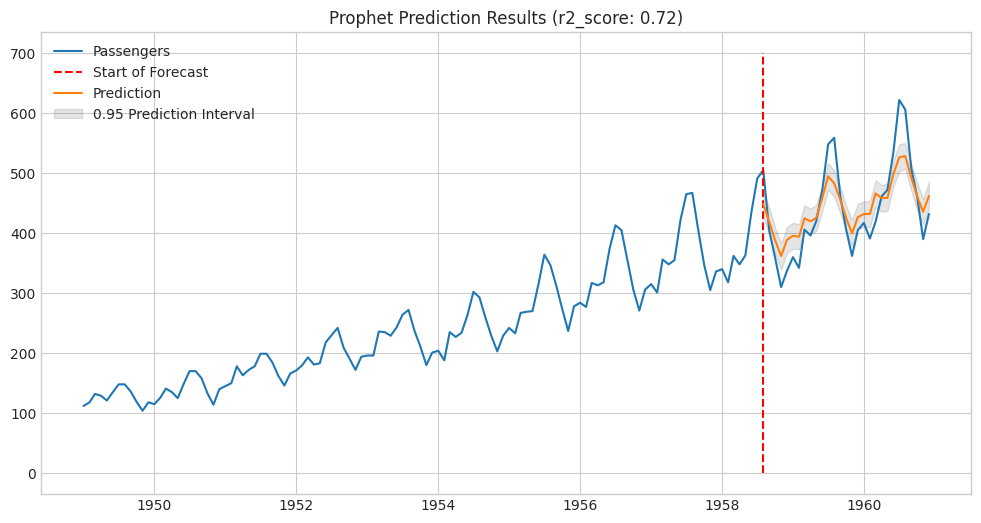

In [79]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('1958-08-01','%Y-%m-%d'), 0, 700, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, PRO_test_pred, label = 'Prediction')
ax.fill_between(predict_index, PRO_test_lb, PRO_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.title(f'Prophet Prediction Results (r2_score: {np.round(r2_score(test, PRO_test_pred), 2)})')
plt.show()

In [80]:
'''
Moving Average
'''
MA_train_pred = train.rolling(5).mean() # Option: min_periods=1
MA_train_pred.columns = ['MA_5']
MA_test_pred = pd.DataFrame(np.array([MA_train_pred.iloc[-1]]*len(test)), index=test.index, columns=['MA_5'])

'''
Simple Eponential Smoothing
'''
L_0 = np.mean(train)  # initial value

SES_train = train.copy()
SES_train = pd.concat([pd.DataFrame(np.zeros(1), columns=['passengers']), SES_train])
SES_train['Level'] = np.nan
SES_train['Forecast'] = np.nan
SES_train.loc[0,'Level'] = L_0.values

SES_train_pred_09 = pd.concat([pd.DataFrame([L_0], columns=['passengers']), train]).ewm(alpha=0.9, adjust=False).mean().iloc[1:]
SES_train_pred_09.columns = ['SES_09']
SES_test_pred_09 = pd.DataFrame(np.array([SES_train_pred_09.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_09'])

'''
Double Eponential Smoothing
'''
train_reg = train.reset_index()
x = np.array(train_reg.index)
y = train_reg['passengers']

x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()

print(results.summary())
L_0, B_0 = results.params

DES_train = train.copy()
DES_train = pd.concat([pd.DataFrame(np.zeros(1), columns=['passengers']), DES_train])
DES_train['Level'] = np.nan
DES_train['Trend'] = np.nan
DES_train['Forecast'] = np.nan

DES_train.loc[0,'Level'] = L_0
DES_train.loc[0,'Trend'] = B_0

def Double_Exponential_Smoothing(table, alpha, beta):
    # table = DES_train.copy()
    # alpha = 0.16
    # beta = 0.1
    for i in range(len(table)):
        if i == 0: # Skip initialization point
            continue

        x = table.loc[list(table.index)[i],'passengers']
        L_prev = table.loc[list(table.index)[i-1],'Level']
        T_prev = table.loc[list(table.index)[i-1],'Trend']
        
        table.loc[list(table.index)[i],'Level'] = alpha*x + (1-alpha)*(L_prev+T_prev)
        table.loc[list(table.index)[i],'Trend'] = beta*(table.loc[list(table.index)[i],'Level']-L_prev) + (1-beta)*(T_prev)

        L_Pred = table.iloc[-1,1]
        T_Pred = table.iloc[-1,2]
        
        DES_test_pred = L_Pred + range(len(test))*T_Pred
        DES_test_pred = pd.DataFrame(DES_test_pred, index = test.index, columns=['DES'])
        
    return table, DES_test_pred

DES_train_pred, DES_test_pred = Double_Exponential_Smoothing(DES_train, 0.1, 0.1)

'''
Additive Holt-winter
'''

HW_add_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit(optimized=True)
HW_add_train_pred = HW_add_model.fittedvalues
HW_add_test_pred = HW_add_model.forecast(len(test))
HW_add_test_pred = pd.DataFrame(HW_add_test_pred, index=test.index, columns=['HW_add'])


'''
Multiplicative Holt-winter
'''
HW_mul_model = ExponentialSmoothing(train, trend='mul', seasonal='mul').fit(optimized=True)
HW_mul_train_pred = HW_mul_model.fittedvalues
HW_mul_test_pred = HW_mul_model.forecast(len(test))
HW_mul_test_pred = pd.DataFrame(HW_mul_test_pred, index=test.index, columns=['HW_mul'])


                            OLS Regression Results                            
Dep. Variable:             passengers   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     600.9
Date:                Wed, 08 Feb 2023   Prob (F-statistic):           4.79e-47
Time:                        17:07:26   Log-Likelihood:                -575.87
No. Observations:                 115   AIC:                             1156.
Df Residuals:                     113   BIC:                             1161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.6742      6.764     14.293      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [81]:
'''
Quantitative Evaluation
'''
print('-'*55)
print('Moving Average (N = 5)')
print(f'MSE: {np.round(mean_squared_error(test, MA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,MA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, MA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, MA_test_pred), 2)}')

print('-'*55)
print('Simple Exponential Smoothing (alpha = 0.9)')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_09), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_09)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_09), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred_09), 2)}')

print('-'*55)
print('Double Exponential Smoothing (alpha = 0.16, beta = 0.1)')
print(f'MSE: {np.round(mean_squared_error(test, DES_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,DES_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, DES_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, DES_test_pred), 2)}')

print('-'*55)
print('Additive Holt-Winter Exponential Smoothing')
print(f'MSE: {np.round(mean_squared_error(test, HW_add_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,HW_add_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_add_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_add_test_pred), 2)}')

print('-'*55)
print('Multiplicative Holt-Winter Exponential Smoothing')
print(f'MSE: {np.round(mean_squared_error(test, HW_mul_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,HW_mul_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_mul_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_mul_test_pred), 2)}')

print('-'*55)
print(f'ARIMA {ARIMA_optimal[0][0]}')
print(f'MSE: {np.round(mean_squared_error(test, ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')

print('-'*55)
print(f'SARIMA {SARIMA_optimal[0][0][0]},{SARIMA_optimal[0][0][1]}')
print(f'MSE: {np.round(mean_squared_error(test, SARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SARIMA_test_pred), 2)}')

print('-'*55)
print('Prophet')
print(f'MSE: {np.round(mean_squared_error(test, PRO_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,PRO_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, PRO_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, PRO_test_pred), 2)}')

-------------------------------------------------------
Moving Average (N = 5)
MSE: 7745.58
RMSE: 88.01
MAE: 64.73
R2 score: -0.27
-------------------------------------------------------
Simple Exponential Smoothing (alpha = 0.9)
MSE: 8071.91
RMSE: 89.84
MAE: 78.17
R2 score: -0.32
-------------------------------------------------------
Double Exponential Smoothing (alpha = 0.16, beta = 0.1)
MSE: 4988.28
RMSE: 70.63
MAE: 57.25
R2 score: 0.18
-------------------------------------------------------
Additive Holt-Winter Exponential Smoothing
MSE: 1541.4
RMSE: 39.26
MAE: 31.79
R2 score: 0.75
-------------------------------------------------------
Multiplicative Holt-Winter Exponential Smoothing
MSE: 455.33
RMSE: 21.34
MAE: 17.46
R2 score: 0.93
-------------------------------------------------------
ARIMA (1, 1, 2)
MSE: 6828.67
RMSE: 82.64
MAE: 62.06
R2 score: -0.12
-------------------------------------------------------
SARIMA (2, 1, 1),(2, 1, 2, 12)
MSE: 33104915.1
RMSE: 5753.69
MAE: 5696.

### 5. Case Study: 주가예측

In [82]:
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    return code

In [83]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_data # 2380 rows × 9 

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DRB동일,4840,고무제품 제조업,"고무벨트(V벨트,콘베이어벨트,평벨트),프라스틱제품 제조,판매",1976-05-21,12월,류영식,http://drbworld.com,부산광역시
1,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
2,GS,78930,기타 금융업,지주회사/부동산 임대,2004-08-05,12월,"허태수, 홍순기 (각자 대표이사)",NaN,서울특별시
3,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"최익훈, 정익희, 김회언 (각자 대표이사)",http://www.hdc-dvp.com,서울특별시
4,KG케미칼,1390,기초 화학물질 제조업,"콘크리트혼화제, 비료, 친환경농자재, 수처리제",1989-08-25,12월,"곽정현, 김재익",http://www.kgchem.co.kr,울산광역시
...,...,...,...,...,...,...,...,...,...
2572,카이바이오텍,446600,의약품 제조업,방사성 진단 및 치료 의약품,2022-12-23,12월,김영덕,http://www.kaibiotech.com/,전라북도
2573,코스텍시스템,169670,특수 목적용 기계 제조업,"반도체 웨이퍼 이송장비, 본딩장비",2022-01-21,12월,배준호,http://www.kosteks.com/,경기도
2574,타임기술,318660,소프트웨어 개발 및 공급업,"ILS(종합군수지원), IETM(전자식기술교범), CBT(전자식교보재), 기술번역",2021-06-24,12월,주양효,http://timett.co.kr,경상남도
2575,플럼라인생명과학,222670,자연과학 및 공학 연구개발업,"강아지암치료제,돼지DNA테라피",2015-07-28,12월,김앤토니경태,http://www.plsdna.com,서울특별시


In [84]:
code_data = code_data[['회사명', '종목코드']]
code_data = code_data.rename(columns={'회사명': 'name', '종목코드': 'code'})
code_data.code = code_data.code.map('{:06d}'.format)

In [89]:
# import yfinance as yfin
# yfin.pdr_override()

stock_code = get_code(code_data, 'LG전자')
stock_data = pdr.DataReader(stock_code, 'naver', start='2021-01-01', end='2023-02-09')


'''
Open: 장 시작 때 주가(시가)
High: 장 중 제일 높았던 주가(고가)
Low: 장 중 제일 낮았던 주가(저가)
Close: 장 닫을 때 주가(종가)
Volume: 주식 거래량

'''

stock_data

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,136500,144000,136500,142000,1868234
2021-01-05,139000,140000,137000,140000,1602818
2021-01-06,148500,150500,137000,137500,5283488
2021-01-07,139500,155000,137000,150000,9782722
2021-01-08,145000,151000,140500,147500,9472733
...,...,...,...,...,...
2023-02-02,100100,101500,99000,100900,727164
2023-02-03,101300,102100,100200,100800,493356
2023-02-06,100900,102900,100000,101600,663779


<AxesSubplot: xlabel='Date'>

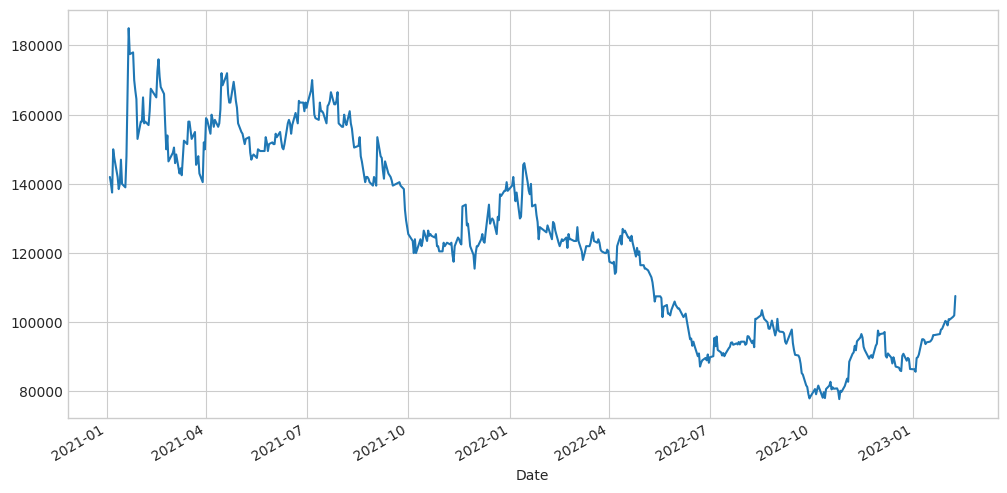

In [90]:
stock_data = stock_data['Close'].astype('int')
fig, ax = plt.subplots(figsize=(12, 6))
stock_data.plot(ax = ax)

In [91]:
from sklearn.model_selection import train_test_split
stock_data_train, stock_data_test = train_test_split(stock_data, test_size=0.1, shuffle=False)

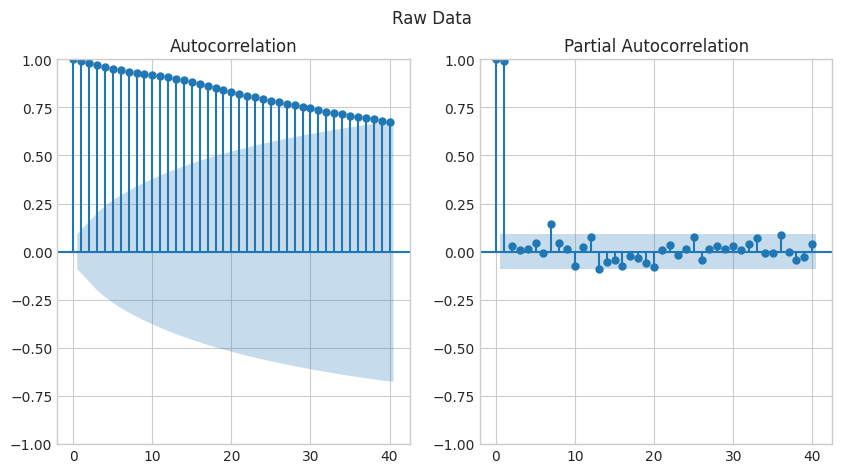

In [92]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(stock_data_train.values.squeeze(), lags=40, ax=ax[1]); # Modify not to generate graph twice

In [93]:
diff_stock_data_train = stock_data_train.copy()
diff_stock_data_train = diff_stock_data_train.diff()
diff_stock_data_train = diff_stock_data_train.dropna()
print('####### Raw Data #######')
print(stock_data_train)
print('### Differenced Data ###')
print(diff_stock_data_train)

####### Raw Data #######
Date
2021-01-04    142000
2021-01-05    140000
2021-01-06    137500
2021-01-07    150000
2021-01-08    147500
               ...  
2022-11-17     92900
2022-11-18     92000
2022-11-21     90100
2022-11-22     89500
2022-11-23     90200
Name: Close, Length: 468, dtype: int64
### Differenced Data ###
Date
2021-01-05    -2000.0
2021-01-06    -2500.0
2021-01-07    12500.0
2021-01-08    -2500.0
2021-01-11    -5500.0
               ...   
2022-11-17    -2700.0
2022-11-18     -900.0
2022-11-21    -1900.0
2022-11-22     -600.0
2022-11-23      700.0
Name: Close, Length: 467, dtype: float64


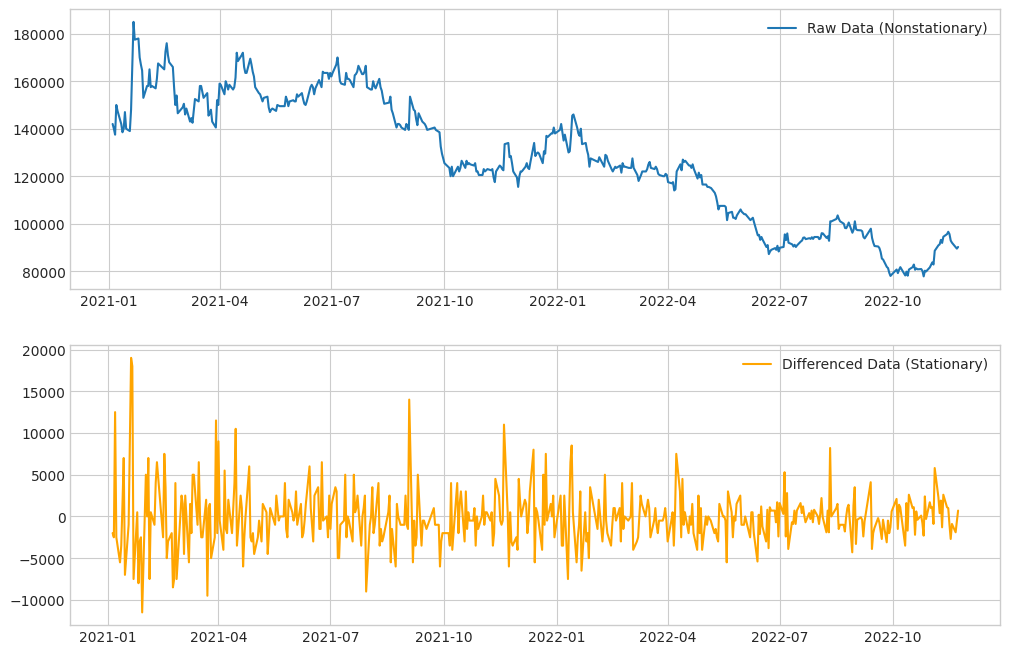

In [94]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(stock_data_train)
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_stock_data_train,'orange') # first difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

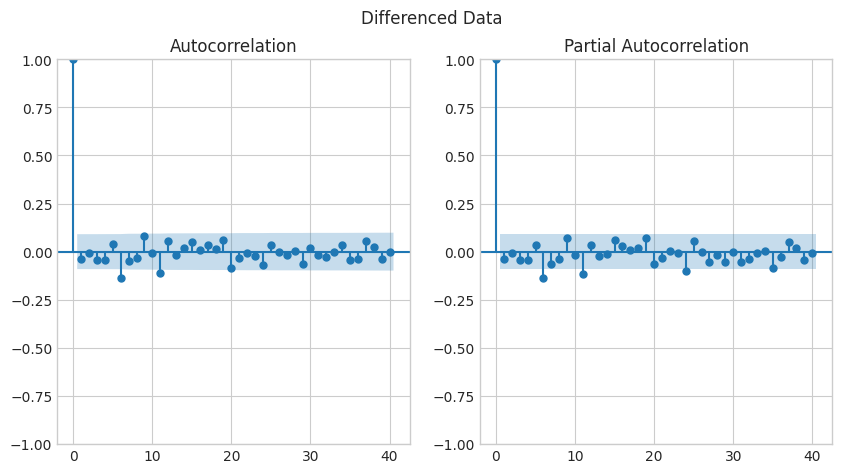

In [95]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_stock_data_train.values.squeeze(), lags=40, ax=ax[1]); # Modify not to generate graph twice

In [96]:
# Parameter search 

auto_arima_model = auto_arima(stock_data_train, start_p=1, start_q=1,
                              max_p=3, max_q=3, seasonal=False,
                              d=1,
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8936.893, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8938.248, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8939.996, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8936.605, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8938.123, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8940.234, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8937.719, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8937.760, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8939.653, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8937.245, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8923.069, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8906.816, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8934.321, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8935.582, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8937.710, Time=0.10 sec

Best mode

In [97]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  468
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -4446.408
Date:                Wed, 08 Feb 2023   AIC                           8906.816
Time:                        17:10:20   BIC                           8935.840
Sample:                             0   HQIC                          8918.238
                                - 468                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -131.0480    238.747     -0.549      0.583    -598.984     336.888
ar.L1          0.3992      0.026     15.613      0.000       0.349       0.449
ar.L2         -0.8783      0.025    -34.938      0.000      -0.928      -0.829
ma.L1         -0.4229      0.041    -10.391      0.000      -0.503      -0.343
ma.L2          0.9276      0.027     34.120      0.000       0.874       0.981
ma.L3          0.0368      0.029      1.254      0.210      -0.021       0.094
sigma2      1.041e+07      0.030   3.52e+08      0.000    1.04e+07    1.04e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               238.56
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.28e+23. Standard errors may be unstable.
"""

In [98]:
AUTO_ARIMA_prediction = auto_arima_model.predict(len(stock_data_test), return_conf_int=True)
AUTO_ARIMA_test_pred = AUTO_ARIMA_prediction[0]
AUTO_ARIMA_test_ub = AUTO_ARIMA_prediction[1][:,0]
AUTO_ARIMA_test_lb = AUTO_ARIMA_prediction[1][:,1]
predict_index = list(stock_data_test.index)
predict_index[0]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Timestamp('2022-11-24 00:00:00')

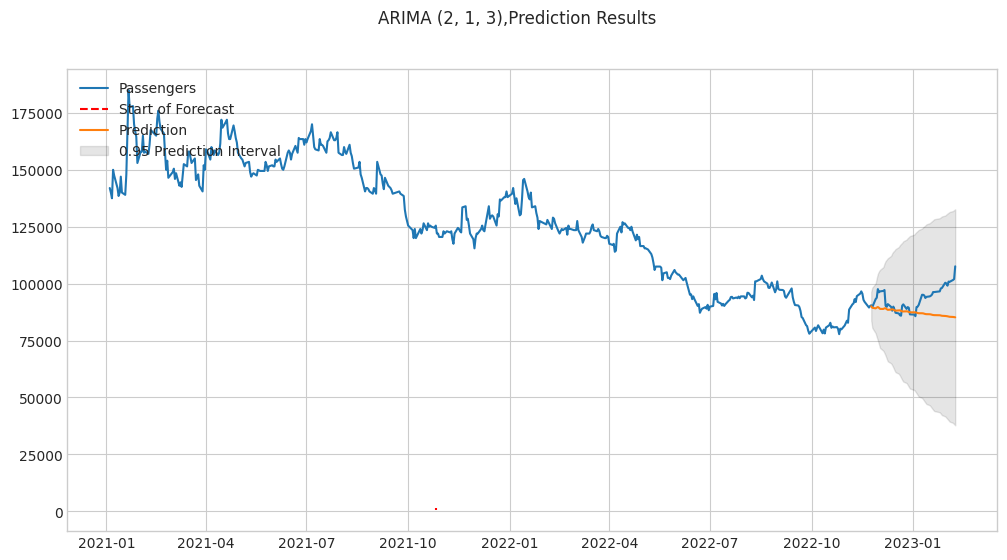

In [99]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(stock_data.index, stock_data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('2021-10-26','%Y-%m-%d'), 500, 1500, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, AUTO_ARIMA_test_pred, label = 'Prediction')
ax.fill_between(predict_index, AUTO_ARIMA_test_lb, AUTO_ARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order},Prediction Results')
plt.show()

In [100]:
stock_data_train_prophet = stock_data_train.reset_index()
stock_data_train_prophet.columns = ['ds', 'y']

PRO_model = Prophet()
PRO_model.fit(stock_data_train_prophet)

stock_data_test_prophet = stock_data_test.reset_index()
stock_data_test_prophet.columns = ['ds', 'y']
stock_data_test_index = stock_data_test_prophet[['ds']]

17:10:51 - cmdstanpy - INFO - Chain [1] start processing
17:10:51 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
PRO_prediction = PRO_model.predict(stock_data_test_index)
PRO_prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-11-24,81192.365046,73921.042597,92714.219960,81192.365046,81192.365046,2217.430350,2217.430350,2217.430350,2217.430350,2217.430350,2217.430350,0.0,0.0,0.0,83409.795396
1,2022-11-25,81096.910839,74015.229495,92037.270214,81096.910839,81096.910839,2010.828784,2010.828784,2010.828784,2010.828784,2010.828784,2010.828784,0.0,0.0,0.0,83107.739623
2,2022-11-28,80810.548219,73587.004574,92222.059994,80810.548219,80810.548219,2272.104251,2272.104251,2272.104251,2272.104251,2272.104251,2272.104251,0.0,0.0,0.0,83082.652469
3,2022-11-29,80715.094012,73907.149878,92918.463098,80715.094012,80715.094012,2138.758831,2138.758831,2138.758831,2138.758831,2138.758831,2138.758831,0.0,0.0,0.0,82853.852842
4,2022-11-30,80619.639805,73800.951784,92033.010772,80603.544623,80634.920838,2238.496128,2238.496128,2238.496128,2238.496128,2238.496128,2238.496128,0.0,0.0,0.0,82858.135933
5,2022-12-01,80524.185598,73205.192841,91261.513229,80479.308346,80569.742591,2217.430350,2217.430350,2217.430350,2217.430350,2217.430350,2217.430350,0.0,0.0,0.0,82741.615948
6,2022-12-02,80428.731391,73249.992351,92357.498828,80350.747579,80511.429255,2010.828784,2010.828784,2010.828784,2010.828784,2010.828784,2010.828784,0.0,0.0,0.0,82439.560175
7,2022-12-05,80142.368770,72778.628545,91870.304124,80030.209395,80267.017965,2272.104251,2272.104251,2272.104251,2272.104251,2272.104251,2272.104251,0.0,0.0,0.0,82414.473021
8,2022-12-06,80046.914563,72962.573325,91331.957085,79891.865576,80226.538327,2138.758831,2138.758831,2138.758831,2138.758831,2138.758831,2138.758831,0.0,0.0,0.0,82185.673394
9,2022-12-07,79951.460356,72666.769894,91792.798140,79759.060760,80167.070850,2238.496128,2238.496128,2238.496128,2238.496128,2238.496128,2238.496128,0.0,0.0,0.0,82189.956484


In [102]:
PRO_test_pred = PRO_prediction['yhat'].values
PRO_test_ub = PRO_prediction['yhat_upper'].values
PRO_test_lb = PRO_prediction['yhat_lower'].values
predict_index = list(stock_data_test.index)

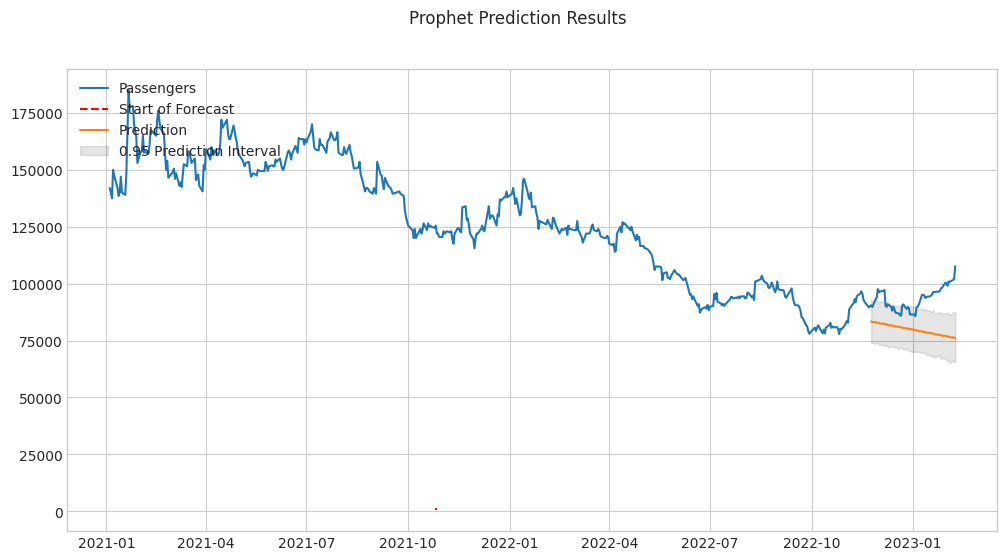

In [103]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(stock_data.index, stock_data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('2021-10-26','%Y-%m-%d'), 500, 1500, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, PRO_test_pred, label = 'Prediction')
ax.fill_between(predict_index, PRO_test_lb, PRO_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle('Prophet Prediction Results')
plt.show()

# EOD